# Understanding SAX with toy data

In this notebook, I break down the tslearn code from my previous notebook. My goal is to better understand what happens under the hood of tslearn. To do this, I use a simple, synthetic timeseries and play along with some descriptive analysis (plots, distributions) and off-the-shelf implementations.

I took notes of some points that aren't super clear to me. You can find these open questions as **wishlist** items.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
sns.set()

## My Timeseries
### Generating toy temporal data

Text(0.5,1,'Toy Timeseries')

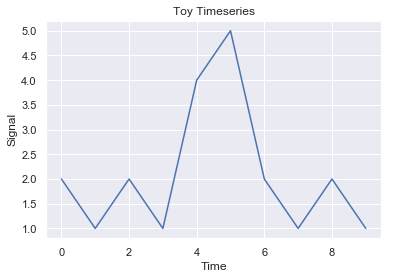

In [2]:
ts = [2,1,2,1,4,5,2,1,2,1]
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Toy Timeseries")

In [3]:
import pandas as pd
pd.Series(ts).describe()

count    10.00000
mean      2.10000
std       1.37032
min       1.00000
25%       1.00000
50%       2.00000
75%       2.00000
max       5.00000
dtype: float64

In [4]:
pd.Series(ts).value_counts()

2    4
1    4
5    1
4    1
dtype: int64

In [5]:
pd.Series(ts).value_counts().describe()

count    4.000000
mean     2.500000
std      1.732051
min      1.000000
25%      1.000000
50%      2.500000
75%      4.000000
max      4.000000
dtype: float64

### Normalizing data

Text(0.5,1,'Toy Timeseries (rescaled)')

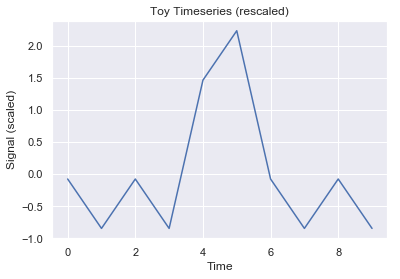

In [6]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler.fit_transform(ts)[0].ravel()
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None)
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries (rescaled)")

In [7]:
pd.Series(ts).describe()

count    1.000000e+01
mean    -1.110223e-17
std      1.054093e+00
min     -8.461538e-01
25%     -8.461538e-01
50%     -7.692308e-02
75%     -7.692308e-02
max      2.230769e+00
dtype: float64

In [8]:
pd.Series(ts).value_counts()

-0.076923    4
-0.846154    4
 1.461538    1
 2.230769    1
dtype: int64

In [9]:
pd.Series(ts).value_counts().describe()

count    4.000000
mean     2.500000
std      1.732051
min      1.000000
25%      1.000000
50%      2.500000
75%      4.000000
max      4.000000
dtype: float64

## Piecewise Aggregating Approximation (PAA)
### Computing Piecewise Aggregating Approximation

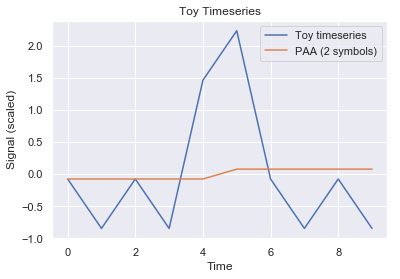

In [10]:
from tslearn.piecewise import PiecewiseAggregateApproximation
n_paa_segments = 2
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
sns.lineplot(x = list(range(len(paa_dataset_inv))), y=paa_dataset_inv, estimator=None, label="PAA (2 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries")
plt.legend()

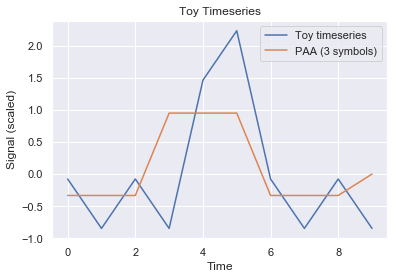

In [11]:
n_paa_segments = 3
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
sns.lineplot(x = list(range(len(paa_dataset_inv))), y=paa_dataset_inv, estimator=None, label="PAA (3 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries")
plt.legend()

**Wishlist**: What do I need to consider to pick an effective number of symbols for PAA?

### PAA Playground

In [12]:
# WRONG APPROACH!
#
# ts = [2,1,2,1,4,5,2,1,2,1]
# n_paa_segments = 2
# print("Number of segments:", n_paa_segments)
# my_percentile = (100/n_paa_segments)
# print("Cutoff percentile:", my_percentile)
# playground_cutoff = np.percentile(ts, my_percentile) # Segmenting ts in n chunks
# print("Cutoff value:", playground_cutoff)
# playground_ts = np.array(ts)
# print("My timeseries:", playground_ts)
# playground_paa = np.piecewise(playground_ts, [playground_ts <= 2, playground_ts > 2], list(range(n_paa_segments)))
# print("My piecewise aggregating approximation:", playground_paa)

# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
# ts = scaler.fit_transform(ts)[0].ravel()

# sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
# sns.lineplot(x = list(range(len(playground_paa))), y=playground_paa, estimator=None, label="PAA (2 symbols)")
# plt.xlabel("Time")
# plt.ylabel("Signal")
# plt.title("Toy Timeseries")
# plt.legend()

In [13]:
# PAA implementation: https://github.com/seninp/saxpy/blob/master/saxpy/paa.py
# Double # comments are mine :)

import numpy as np


def paa(series, paa_segments):
    """PAA implementation."""
    series_len = len(series)

    # check for the trivial case
    if (series_len == paa_segments): ## If the number of chunks == ts length
        return np.copy(series) ## Resturn ts

    else:
        res = np.zeros(paa_segments) ## Initialize a zero array
        # check when we are even
        if (series_len % paa_segments == 0): ## Even-number case scenario
            inc = series_len // paa_segments ## Number of items per chunk (integer)
            for i in range(0, series_len):
                idx = i // inc ## Chunk number
                np.add.at(res, idx, series[i]) ## Update zero array 
                print(idx, res) ## My addition
                # res[idx] = res[idx] + series[i]
            print()
            return res / inc
        # and process when we are odd
        else:
            for i in range(0, paa_segments * series_len): # Odd-number case scenario
                idx = i // series_len ## Chunk number
                pos = i // paa_segments ## 
                np.add.at(res, idx, series[pos]) ## Update zero array 
                print(idx, pos, res) ## My addition
                # res[idx] = res[idx] + series[pos]
            print()
            return res / series_len

In [14]:
even_ts = [2,1,2,1,4,5,2,1,2,1]
print("Timeseries:", even_ts)
print()
paa(even_ts, paa_segments=2)

Timeseries: [2, 1, 2, 1, 4, 5, 2, 1, 2, 1]

0 [2. 0.]
0 [3. 0.]
0 [5. 0.]
0 [6. 0.]
0 [10.  0.]
1 [10.  5.]
1 [10.  7.]
1 [10.  8.]
1 [10. 10.]
1 [10. 11.]



array([2. , 2.2])

In [15]:
print("Timeseries:", even_ts)
print()
paa(even_ts, paa_segments=3)

Timeseries: [2, 1, 2, 1, 4, 5, 2, 1, 2, 1]

0 0 [2. 0. 0.]
0 0 [4. 0. 0.]
0 0 [6. 0. 0.]
0 1 [7. 0. 0.]
0 1 [8. 0. 0.]
0 1 [9. 0. 0.]
0 2 [11.  0.  0.]
0 2 [13.  0.  0.]
0 2 [15.  0.  0.]
0 3 [16.  0.  0.]
1 3 [16.  1.  0.]
1 3 [16.  2.  0.]
1 4 [16.  6.  0.]
1 4 [16. 10.  0.]
1 4 [16. 14.  0.]
1 5 [16. 19.  0.]
1 5 [16. 24.  0.]
1 5 [16. 29.  0.]
1 6 [16. 31.  0.]
1 6 [16. 33.  0.]
2 6 [16. 33.  2.]
2 7 [16. 33.  3.]
2 7 [16. 33.  4.]
2 7 [16. 33.  5.]
2 8 [16. 33.  7.]
2 8 [16. 33.  9.]
2 8 [16. 33. 11.]
2 9 [16. 33. 12.]
2 9 [16. 33. 13.]
2 9 [16. 33. 14.]



array([1.6, 3.3, 1.4])

In [16]:
odd_ts = [2,1,2,1,4,5,2,1,2]
print("Timeseries:", odd_ts)
print()
paa(odd_ts, paa_segments=2)

Timeseries: [2, 1, 2, 1, 4, 5, 2, 1, 2]

0 0 [2. 0.]
0 0 [4. 0.]
0 1 [5. 0.]
0 1 [6. 0.]
0 2 [8. 0.]
0 2 [10.  0.]
0 3 [11.  0.]
0 3 [12.  0.]
0 4 [16.  0.]
1 4 [16.  4.]
1 5 [16.  9.]
1 5 [16. 14.]
1 6 [16. 16.]
1 6 [16. 18.]
1 7 [16. 19.]
1 7 [16. 20.]
1 8 [16. 22.]
1 8 [16. 24.]



array([1.77777778, 2.66666667])

In [17]:
print("Timeseries:", odd_ts)
print()
paa(odd_ts, paa_segments=3)

Timeseries: [2, 1, 2, 1, 4, 5, 2, 1, 2]

0 [2. 0. 0.]
0 [3. 0. 0.]
0 [5. 0. 0.]
1 [5. 1. 0.]
1 [5. 5. 0.]
1 [ 5. 10.  0.]
2 [ 5. 10.  2.]
2 [ 5. 10.  3.]
2 [ 5. 10.  5.]



array([1.66666667, 3.33333333, 1.66666667])

### SAX words transformation

In [18]:
from tslearn.piecewise import SymbolicAggregateApproximation

n_paa_segments = 2
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()

n_sax_symbols = 2
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(ts))

sax_dataset_inv[0].ravel()

array([-0.67448975, -0.67448975, -0.67448975, -0.67448975, -0.67448975,
        0.67448975,  0.67448975,  0.67448975,  0.67448975,  0.67448975])

In [19]:
vocabulary = ['A', 'B']

def map_SAX_vocabulary(sax, vocabulary):
    unique_values = list(set(sax[0].ravel()))
    print("Unique values:", unique_values)
    result = []
    for i, j in enumerate(sax[0].ravel()):
        print("Evaluating timeseries item #{}: {}".format(i, j))
        x, = np.where(unique_values==j)
        print("\tFetching SAX value #{}: {}".format(x[0], vocabulary[x[0]]))
        result.append(vocabulary[x[0]])
    return result
    
map_SAX_vocabulary(sax_dataset_inv, vocabulary)

Unique values: [-0.6744897501960817, 0.6744897501960817]
Evaluating timeseries item #0: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #1: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #2: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #3: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #4: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #5: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #6: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #7: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #8: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #9: 0.6744897501960817
	Fetching SAX value #1: B


['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']

In [20]:
n_paa_segments = 3
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()

n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(ts))

sax_dataset_inv[0].ravel()

array([0.        , 0.        , 0.        , 0.96742157, 0.96742157,
       0.96742157, 0.        , 0.        , 0.        , 0.        ])

In [21]:
vocabulary = ['A', 'B', 'C']
map_SAX_vocabulary(sax_dataset_inv, vocabulary)

Unique values: [0.0, 0.967421566101701]
Evaluating timeseries item #0: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #1: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #2: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #3: 0.967421566101701
	Fetching SAX value #1: B
Evaluating timeseries item #4: 0.967421566101701
	Fetching SAX value #1: B
Evaluating timeseries item #5: 0.967421566101701
	Fetching SAX value #1: B
Evaluating timeseries item #6: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #7: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #8: 0.0
	Fetching SAX value #0: A
Evaluating timeseries item #9: 0.0
	Fetching SAX value #0: A


['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'A']

In [22]:
n_paa_segments = 3
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()

n_sax_symbols = 2
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(ts))

sax_dataset_inv[0].ravel()

array([-0.67448975, -0.67448975, -0.67448975,  0.67448975,  0.67448975,
        0.67448975, -0.67448975, -0.67448975, -0.67448975,  0.        ])

In [23]:
# WONT'T WORK! Error: List out of range
#
# vocabulary = ['A', 'B']
# map_SAX_vocabulary(sax_dataset_inv, vocabulary)

In [24]:
vocabulary = ['A', 'B', 'C']
map_SAX_vocabulary(sax_dataset_inv, vocabulary)

Unique values: [-0.6744897501960817, 0.6744897501960817, 0.0]
Evaluating timeseries item #0: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #1: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #2: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #3: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #4: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #5: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #6: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #7: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #8: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #9: 0.0
	Fetching SAX value #2: C


['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'C']

**Wishlist**: # of PAA segments needs to be 

- (A) equal to, or

- (B) larger or equal to

\# of SAX symbols?

## SAX Viz

Unique values: [-0.6744897501960817, 0.6744897501960817]
Evaluating timeseries item #0: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #1: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #2: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #3: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #4: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #5: 0.6744897501960817
	Fetching SAX value #1: B
Evaluating timeseries item #6: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #7: -0.6744897501960817
	Fetching SAX value #0: A
Evaluating timeseries item #8: -0.6744897501960817
	Fetching SAX value #0: A

SAX representation: ['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A']


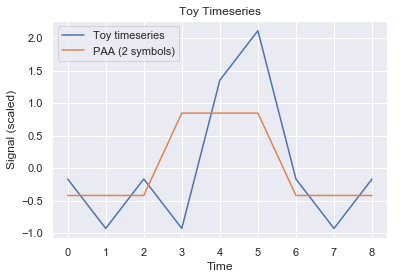

In [25]:
ts = [2,1,2,1,4,5,2,1,2]
# Scaling
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler.fit_transform(ts)[0].ravel()
# PAA
n_paa_segments = 3
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(ts))[0].ravel()

# SAX words
n_sax_symbols = 2
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(ts))
vocabulary = ['A', 'B']
SAX = map_SAX_vocabulary(sax_dataset_inv, vocabulary)
print()
print("SAX representation:", SAX)

sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
sns.lineplot(x = list(range(len(paa_dataset_inv))), y=paa_dataset_inv, estimator=None, label="PAA (2 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries")
plt.legend()


Text(6,-0.422577,'A')

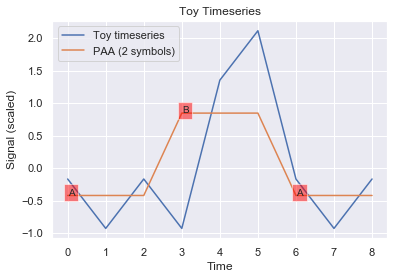

In [26]:
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
sns.lineplot(x = list(range(len(paa_dataset_inv))), y=paa_dataset_inv, estimator=None, label="PAA (2 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries")
plt.legend()
plt.text(0, paa_dataset_inv[0], SAX[0], bbox=dict(facecolor='red', alpha=0.5))
plt.text(3, paa_dataset_inv[3], SAX[3], bbox=dict(facecolor='red', alpha=0.5))
plt.text(6, paa_dataset_inv[6], SAX[6], bbox=dict(facecolor='red', alpha=0.5))

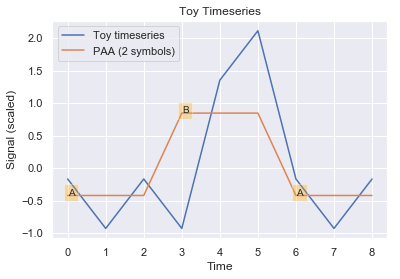

In [27]:
sns.lineplot(x = list(range(len(ts))), y=ts, estimator=None, label="Toy timeseries")
sns.lineplot(x = list(range(len(paa_dataset_inv))), y=paa_dataset_inv, estimator=None, label="PAA (2 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("Toy Timeseries")
plt.legend()

# Annotate SAX word
for i, w in enumerate(SAX):
    if i == 0:
        plt.text(i, paa_dataset_inv[i], SAX[i], bbox=dict(facecolor='orange', alpha=0.3))
        current_letter = SAX[i]
    else:
        if w != current_letter:
            plt.text(i, paa_dataset_inv[i], SAX[i], bbox=dict(facecolor='orange', alpha=0.3))
            current_letter = SAX[i]